<h1>Раздел 1<h1>
<h2>Основы работы с моделями нейронных сетей<h2/>

**Шаг 1**
Импорт библиотек, необходимых для работы.

In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

from torchvision import datasets
from torchvision.transforms import ToTensor, Resize

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Шаг 2**
Загрузка открытых датасетов из пакета datasets фреймворка pytorch

In [3]:
# Загрузка обучающего датасета.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Загрузка тестового датасета.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17030672.65it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268529.71it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5085175.91it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20179698.12it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# Загрузка классов данных, присутствующих в датасете
test_data.classes
#test_data.data

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

**Шаг 3**
После того, как датасеты были загружены, данные из них необходимо упаковать в пакеты (батчи). Основное преимущество нейросетей заключается в параллельной обработке данных, выполняющейся за счет того, что данные подаются на вход группами (батчами), то есть порциями. Чем больше размер пакета (батча), тем выше скорость обучения нейронной сети, но также возрастает ресурсоемкость сети. Таким образом, необходимо **выбирать размер пакета** таким образом, чтобы сохранялся **баланс между скоростью обучения и ресурсоемкостью**. <br/>
Для формирования пакетов используется класс DataLoader. С его помощью можно сформировать батчи необходимой длины, перемешать данные или добавить особую функцию (collate function), которая будет формировать пакеты.<br/>
В ячейке ниже предоставлены входные данные (тензор размерности [N, C, H, W], где N - размер пакета, C - количество каналов (1 - для ч/б изображений, 3 или 4 в зависимости от изображения RGB или RGBA), H и W - height и width, высота и ширина изображения). И выходные данные с указанием метки класса.

In [5]:
batch_size = 64

# Создание загрузчиков данных.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


**Шаг 4** Описание модели. Модель нейронной сети, создается фреймворком pytorch с помощью пакета torch.nn, который мы импортировали на шаге 1. <br/><br/>
Перед этим, необходимо выбрать устройство, на котором будет размещаться наша модель. Обычно существует два варианта: GPU/CUDA (видеокарта) или CPU (процессор). В google colab есть выбор запуска среды как с CUDA так и на CPU.
<br/><br/>
Для того, чтобы описать модель, необходимо создать класс, в нашем случае это класс NeuralNetwork, который будет наследовать интерфейс нейронной сети от класса nn.Module. Согласно этому интерфейсу в классе NeuralNetwork необходимо описать слои нейронной сети в конструкторе класса (*__init__*), а также порядок прохождения и обработки информации через слои с помощью перегрузки метода *forward*.
<br/><br/>
Подробное описание слоев предоставлено в комментариях в коде в ячейке ниже.

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Используемое устройство: {device}")

# Описание нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Используемое устройство: cpu
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Шаг 5** Выбор функции ошибок, алгоритмов оптимизации и определения функции обучения.

In [7]:
#  в данном примере рассматривается многоклассовая классификация, поэтому наиболее
#  рациональным решением будет использование перекрестной энтропии (кросс-энтропии),
#  а в качестве примера алгоритм оптимизации Стохастичный Градиентный Спуск (SGD).
loss_fn = nn.CrossEntropyLoss()
#  параметр lr (learning_rate - шаг обучения) определяет размер шага, которым
#  алгоритм будет достигать максимума градиента.
#  При увеличении lr увеличивается скорость, но ухудшается точность, при уменьшении
#  увеличивается точность, но уменьшается скорость обучения.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #  вычисляем ошибку предсказания модели
        pred = model(X)
        loss = loss_fn(pred, y)

        #  реализация метода обратного распространения ошибки
        #  backward вычисляет градиенты, а step производит обновление весов
        loss.backward()
        optimizer.step()
        #  метод zero_grad производит обнуление градиентов, чтобы это не мешало
        #  дальнейшему обучению сети
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

**Шаг 6** Обучение нейронной сети.<br/>
Эпоха, это итерация, на которой модель использует данные из обучающей выборки.
Согласно гипотезе, чем больше эпох, тем лучше, так как чем больше человек повторит какой либо материал, тем лучше он запомнит его.<br/>
Но в случае с нейронной сетью это не так. При увеличении числа эпох, в какой-то момент произойдет "переобучение сети", из-за чего точность на тестовой выборке начнет падать. Природа данного эффекта заключается в том, что модель слишком сильно настраивается на данные обучающей выборки, из-за чего теряется способность обобщающая способность нейронной сети. Более подробно см: https://proproprogs.ru/neural_network/pereobuchenie-chto-eto-i-kak-etogo-izbezhat-kriterii-ostanova-obucheniya?ysclid=lmlrjx3fbg719891347

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Готово!")

Эпоха 1
-------------------------------
loss: 2.301741  [   64/60000]
loss: 2.290160  [ 6464/60000]
loss: 2.273480  [12864/60000]
loss: 2.270679  [19264/60000]
loss: 2.257380  [25664/60000]
loss: 2.225389  [32064/60000]
loss: 2.235556  [38464/60000]
loss: 2.205257  [44864/60000]
loss: 2.196175  [51264/60000]
loss: 2.170047  [57664/60000]
Test Error: 
 Accuracy: 33.8%, Avg loss: 2.168671 

Эпоха 2
-------------------------------
loss: 2.174998  [   64/60000]
loss: 2.165319  [ 6464/60000]
loss: 2.111555  [12864/60000]
loss: 2.131665  [19264/60000]
loss: 2.089909  [25664/60000]
loss: 2.021708  [32064/60000]
loss: 2.054682  [38464/60000]
loss: 1.977840  [44864/60000]
loss: 1.977145  [51264/60000]
loss: 1.914514  [57664/60000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.915104 

Эпоха 3
-------------------------------
loss: 1.939750  [   64/60000]
loss: 1.909800  [ 6464/60000]
loss: 1.795348  [12864/60000]
loss: 1.841975  [19264/60000]
loss: 1.744345  [25664/60000]
loss: 1.679979  [32064/600

Predicted: "Ankle boot", Actual: "Ankle boot"
Входное изображение:


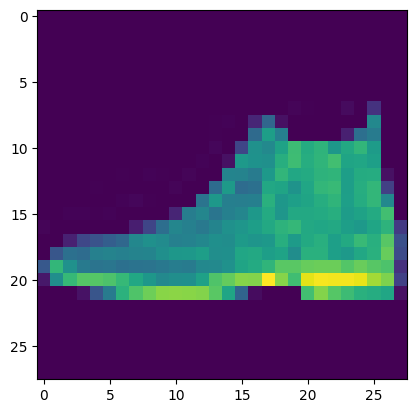

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
print("Входное изображение:")
plt.imshow(np.transpose(x.detach().cpu().numpy(), (1,2,0)))

<h1>Раздел 2<h1>
<h2>Визуализация работы ИИ<h2/>

**Шаг 1** Установка дополнительного пакета *torchcam* для визуализации зон изображений, на основе которых модель принимает решение.

In [12]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 949.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 723.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaud

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.2MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomRe

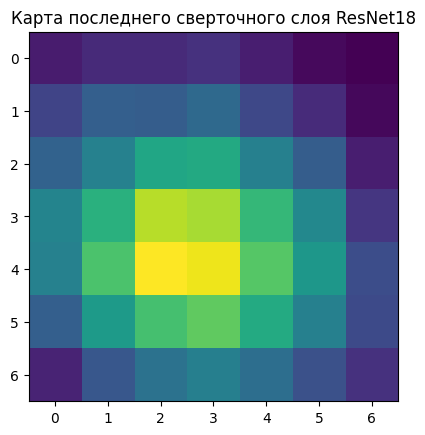

In [13]:
from torchvision.io import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp
from torchvision import transforms

model = resnet18(pretrained=True).eval()
cam_extractor = SmoothGradCAMpp(model)
# Открываем картинку
img = read_image("cat.jpg")
# Предобрабатываем картинку для входа нашей нейронной сети
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Получаем выходные данные на основе модели
out = model(input_tensor.unsqueeze(0))
# Получаем карту активации нейроннов последнего слоя модели resnet18
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
plt.title("Карта последнего сверточного слоя ResNet18")
plt.imshow(np.transpose(activation_map[0].detach().cpu().numpy(), (1, 2, 0)))

**Шаг 3** Наложение маски на исходное изображение

Открываем изображение с помощью cv2

In [14]:
import cv2
img = cv2.imread("cat.jpg")

Растяжка карты до размеров исходного изображения

In [15]:
heatmap = cv2.resize(activation_map[0].squeeze(0).numpy(), (img.shape[1], img.shape[0]))

Преобразование карты в RGB, наложение на изображение.

Text(0.5, 1.0, 'cat.jpg')

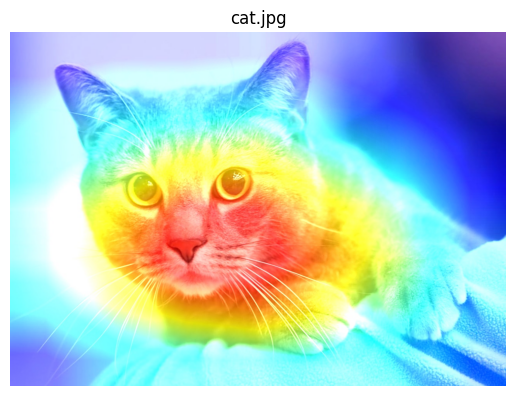

In [16]:
# Загрузить фото кота в локальную среду выполнения ноутбука (сессионное хранилище)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img
plt.imshow(superimposed_img)
output = 'output.jpg'
cv2.imwrite(output, superimposed_img)
img=mpimg.imread(output)
plt.imshow(img)
plt.axis('off')
plt.title("cat.jpg")

<h1>Раздел 3</h1>
<h2>Применение state-of-the-art решений на примере датасета FGVAircraft</h2>

**Шаг 1** Аугментация данных.<br/>
Аугментация данных - это умышленное изменение/искажение исходных данных, для улучшения обобщающих способностей при обучении нейронной сети. В качестве аугментации изображений применяют различные повороты, наклоны изображений, изменение цветовых параметров пикселей и т.д.

In [17]:
# описание функции трансформации изображений для реализации аугментаци
augmentation = transforms.Compose([
    # приведение матрицы к тензору pytorch
    ToTensor(),
    # уменьшение размера до 224 на 224 (требование большинства архитектур resnet, vgg ....)
    transforms.Resize((224, 224)),
    # случайное отражение по горизонтали
    transforms.RandomHorizontalFlip(),
    # слаучайное отражение по вертикали
    transforms.RandomVerticalFlip(),
    # случайный поворот изображения до 20 градусов
    transforms.RandomRotation(20),
    # случайное изменение яркости и оттенка изображения
    transforms.ColorJitter(brightness=.3, hue=.2)
])
# подробнее обо всех методах модуля transforms можно узнать в документации https://pytorch.org/vision/stable/transforms.html

In [18]:
train = datasets.FGVCAircraft(
      "data",
      annotation_level="manufacturer",
      split="train",
      download=True,
      transform=augmentation
    )

test = datasets.FGVCAircraft(
      "data",
      annotation_level="manufacturer",
      split="test",
      download=True,
      transform=transforms.Compose([ToTensor(), transforms.Resize((224, 224))])
    )

100%|██████████| 2753340328/2753340328 [01:28<00:00, 31025992.10it/s]


Extracting data/fgvc-aircraft-2013b.tar.gz to data


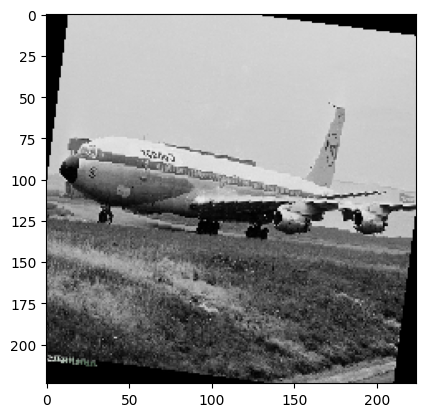

In [19]:
# изображение после аугментации
plt.imshow(np.transpose(train[0][0], (1, 2, 0)))

In [20]:
# создание загрузчиков данных, которые будут формировать и подавать данные пакетам на вход модели
train_dl = DataLoader(train, batch_size=16, shuffle=True)
test_dl = DataLoader(test, batch_size=4, shuffle=False)

**Шаг 2** Определение модели. Будем использовать готовую модель архитектуры resnet с 50 слоями.

In [21]:
from torchvision.models import resnet50

# создание экземпляра модели и инициализация весами, полученными при обучении на датасете ImageNet
model = resnet50(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
#  так как в филнальном размер выходного вектора больше необходимого нам количества классов, изменим его!
"Кол-во классов в датасете", len(train.classes), "Кол-во классов предсказываемых моделью:", model.fc.out_features

('Кол-во классов в датасете',
 30,
 'Кол-во классов предсказываемых моделью:',
 1000)

In [23]:
#  изменение размерности выходного вектора и загрузка модели на устройство (cpu или gpu)
model.fc = nn.Linear(model.fc.in_features, len(train.classes))
model = model.to(device)

**Шаг 3** Обучение нейронной сети. Функция для обучения и теста написаны по аналогии с такими же в разделе 1.

In [24]:
def train_fn(model, loader, criterion, optimizer):
    total_loss, total_acc = 0, 0

    model.train()

    for batch, (x, y) in enumerate(loader):
      optimizer.zero_grad()
      x,y = x.to(device), y.to(device)
      out = model(x)

      loss = criterion(out, y)

      # рассчет точности
      total_acc += (out.argmax(-1) == y).sum() / out.size(0)
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

      if (batch + 1) % 100 == 0:
        print("-" * 90)
        print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    return total_loss / len(loader), total_acc / len(loader)

In [25]:
def evaluate(model, loader, criterion):
    total_acc, total_loss = 0, 0
    model.eval()

    with torch.no_grad():
      for batch, (x,y) in enumerate(loader):
        x,y = x.to(device), y.to(device)
        out = model(x)

        loss = criterion(out, y)

        total_acc += (out.argmax(-1) == y).sum() / out.size(0)
        total_loss += loss.item()

        if (batch + 1) % 100 == 0:
          print("-" * 90)
          print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    return total_loss / len(loader), total_acc / len(loader)

In [26]:
epochs = 5

train_accs, train_losses = [], []
test_accs, test_losses = [], []

# перекрестная энтропия для рассчета ошибки мультиклассовой классификации
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(f"Process started on device: {device}")

for epoch in range(1, epochs + 1):
    loss, acc = train_fn(model, train_dl, criterion, optimizer)
    train_accs.append(acc.detach().cpu().item())
    train_losses.append(loss)
    print("-" * 90)
    print(f"| epoch: {epoch} | train_acc: {acc} | train_loss: {loss} |")
    eloss, eacc = evaluate(model, test_dl, criterion)
    test_accs.append(eacc.detach().cpu().item())
    test_losses.append(eloss)
    print(f"| epoch: {epoch} | test_acc: {eacc}  | test_loss: {eloss}  |")

Process started on device: cpu
------------------------------------------------------------------------------------------
loss: 2.635180630683899 acc: 0.24625 | batch: 100 / 209 |
------------------------------------------------------------------------------------------
loss: 2.336851400732994 acc: 0.3059375 | batch: 200 / 209 |
------------------------------------------------------------------------------------------
| epoch: 1 | train_acc: 0.3073165714740753 | train_loss: 2.326505661010742 |
------------------------------------------------------------------------------------------
loss: 1.1960254675149917 acc: 0.57 | batch: 100 / 834 |
------------------------------------------------------------------------------------------
loss: 1.110783859193325 acc: 0.58875 | batch: 200 / 834 |
------------------------------------------------------------------------------------------
loss: 1.1673394271234672 acc: 0.5683333333333334 | batch: 300 / 834 |
--------------------------------------------

In [27]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix


def accuracy(pred, y):
    """функция для расчета точности"""
    vals = (pred.argmax(-1) == y)
    return vals.sum() / pred.size(0)


def build_classification_report(pred, y):
    """функция для построения отчета о классификации, выводит для каждого класса
    полноту, точность, Ф1 меру, поддержку, и макро и средне взвешенные метрики
    для всех классов"""
    return classification_report(y, pred, target_names=train.classes)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """функция для отображения матрицы ошибок классификации"""
    plt.figure(figsize=(20,20), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')

In [28]:
#  прогон модели на тестовой выборке для получения меток для дальнейшего расчета метрик
preds = []
ys = []
model.eval()
with torch.no_grad():
  for batch, (x, y) in enumerate(test_dl):
    predicted = model(x.to(device))
    preds.extend(predicted.argmax(-1).detach().cpu().tolist())
    ys.extend(y.tolist())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


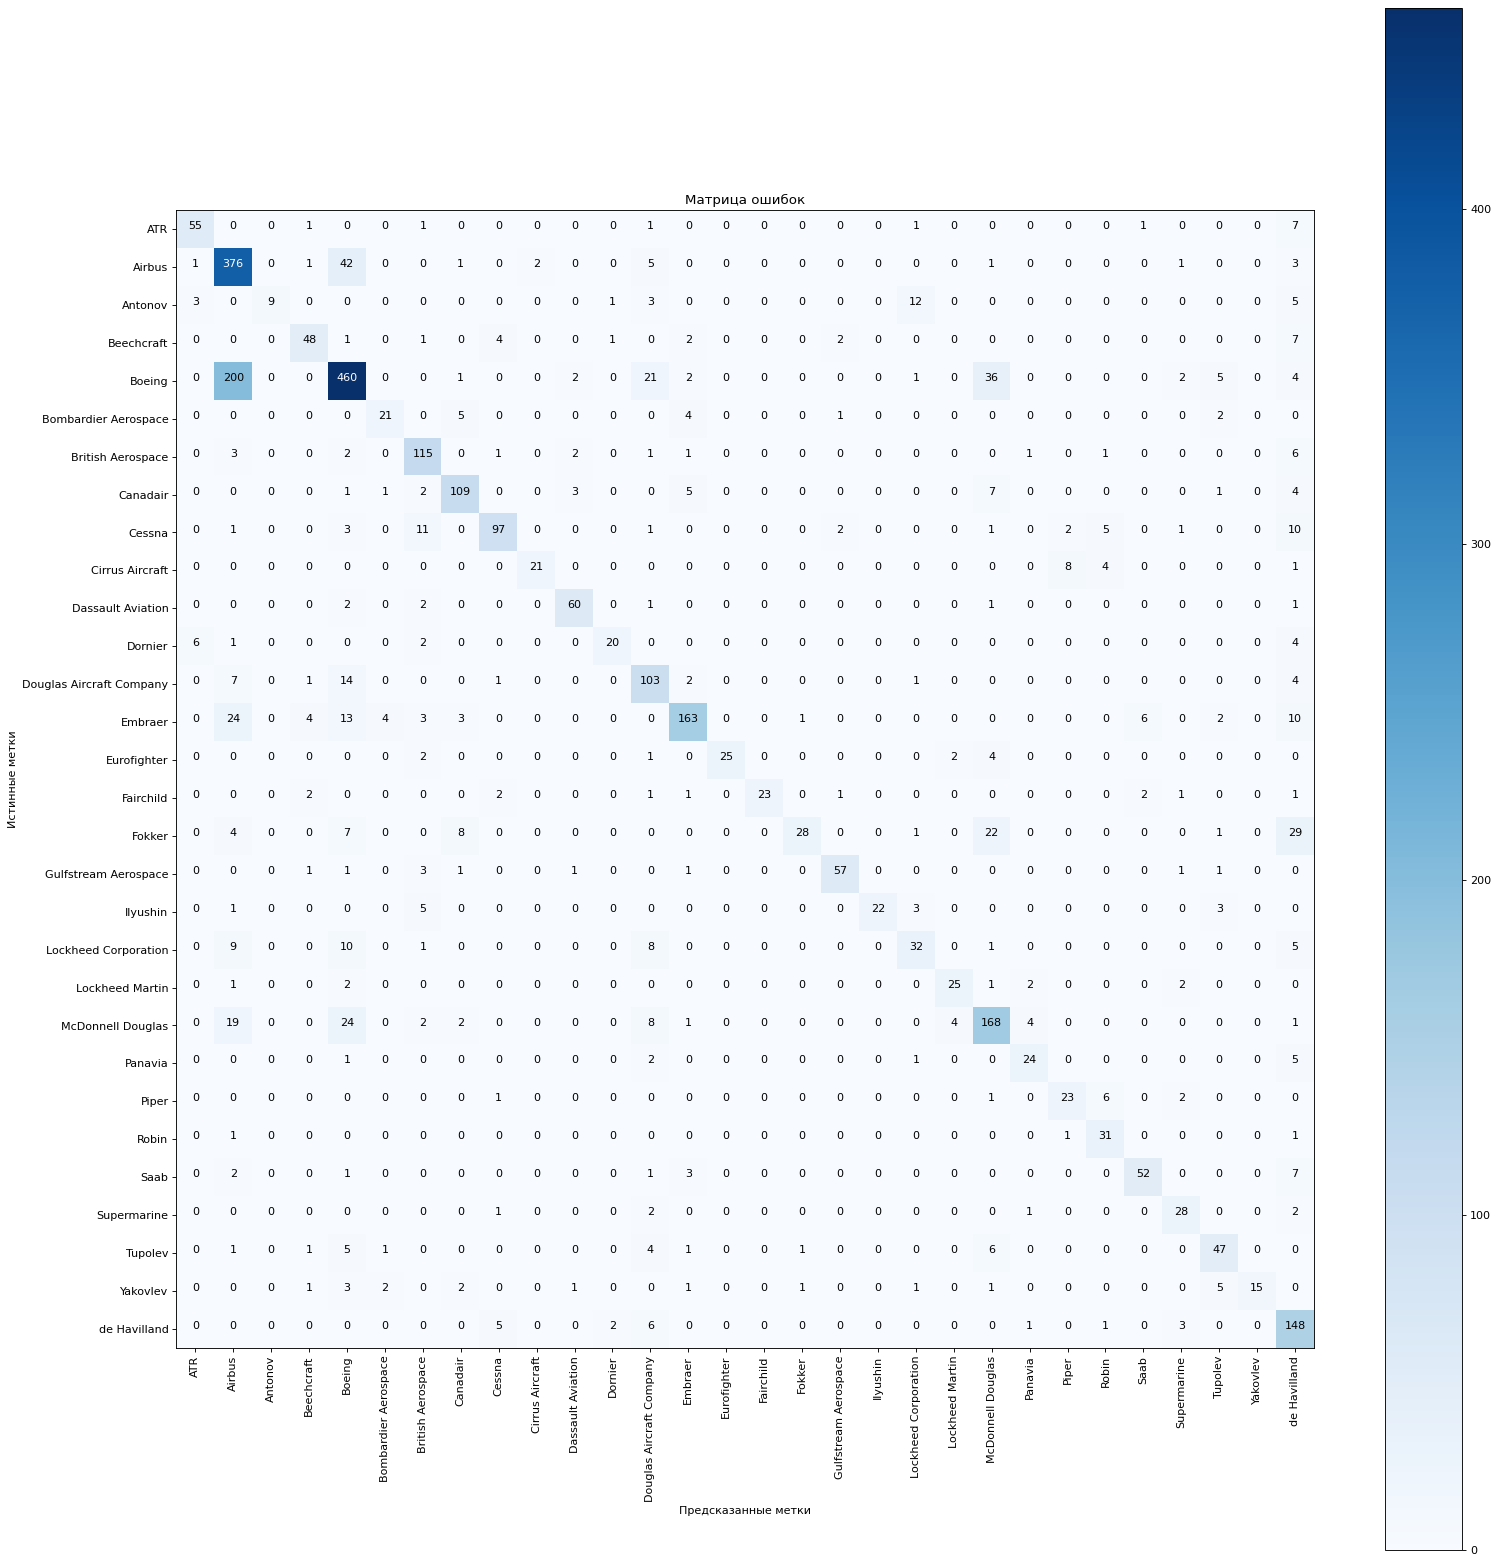

In [29]:
plot_confusion_matrix(confusion_matrix(ys, preds), train.classes)

In [30]:
# не имеет смысла в данном случае, так как слишком много классов
# самостоятельно измените функцию build_classification_report для вывода отчета в файл!
build_classification_report(preds, ys)

'                          precision    recall  f1-score   support\n\n                     ATR       0.85      0.82      0.83        67\n                  Airbus       0.58      0.87      0.69       433\n                 Antonov       1.00      0.27      0.43        33\n              Beechcraft       0.80      0.73      0.76        66\n                  Boeing       0.78      0.63      0.69       734\n    Bombardier Aerospace       0.72      0.64      0.68        33\n       British Aerospace       0.77      0.86      0.81       133\n                Canadair       0.83      0.82      0.82       133\n                  Cessna       0.87      0.72      0.79       134\n         Cirrus Aircraft       0.91      0.62      0.74        34\n       Dassault Aviation       0.87      0.90      0.88        67\n                 Dornier       0.83      0.61      0.70        33\nDouglas Aircraft Company       0.61      0.77      0.68       133\n                 Embraer       0.87      0.70      0.78    

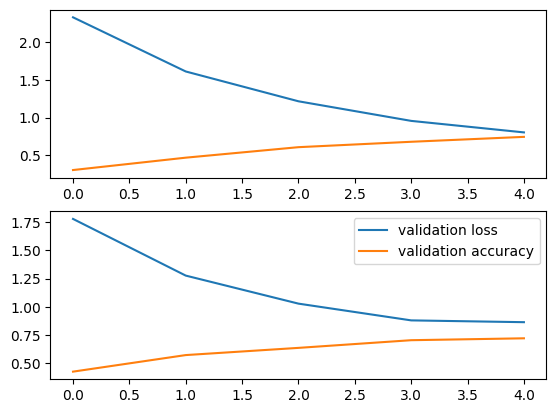

In [31]:
# график изменения ошибки и точности от эпохи
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(train_losses, label = 'training loss')
fig1.plot(train_accs, label = 'training accuracy')
fig2.plot(test_losses, label = 'validation loss')
fig2.plot(test_accs, label = 'validation accuracy')
plt.legend()
plt.show()

**Задание** создайте тепловую карту последнего сверточного слоя модели resnet50, посмотрите и проанализируйте, корректно ли модель делает акцент для принятия решения или использует косвенные признаки (читерит)!

<H1>Раздел 4</H1>
<h2>Классификация дорожных знаков</h2>

In [32]:
def augmentation_fn_builder(img_size):
    augmentation = transforms.Compose([
        ToTensor(),
        transforms.Resize((img_size, img_size)),
        # "дополните функцию другими методами аугментации изображений"
    ])
    return augmentation


train = datasets.GTSRB(
    "data",
    split="train",
    download=True,
    transform=augmentation_fn_builder(224)
)

test = datasets.GTSRB(
    "data",
    split="test",
    download=True,
    transform=transforms.Compose([ToTensor(), transforms.Resize((224, 224))])
)

100%|██████████| 187490228/187490228 [00:08<00:00, 22562387.57it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 88978620/88978620 [00:03<00:00, 22585097.71it/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 297565.61it/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [33]:
unique = []
for x, y in train:
  if y not in unique:
    unique.append(y)
len(unique)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


43

In [34]:
train_dl = DataLoader(train, batch_size=16, shuffle=True)
test_dl = DataLoader(test, batch_size=14, shuffle=False)

In [35]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(2048, len(unique))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
def train_fn(model, loader, criterion, optimizer):
    total_loss, total_acc = 0, 0

    model.train()

    for batch, (x, y) in enumerate(loader):
      optimizer.zero_grad()
      x,y = x.to(device), y.to(device)
      out = model(x)

      loss = criterion(out, y)

      # рассчет точности
      total_acc += (out.argmax(-1) == y).sum() / out.size(0)
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

      if (batch + 1) % 100 == 0:
        print("-" * 90)
        print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    return total_loss / len(loader), total_acc / len(loader)


def evaluate(model, loader, criterion):
    total_acc, total_loss = 0, 0
    model.eval()

    with torch.no_grad():
      for batch, (x,y) in enumerate(loader):
        x,y = x.to(device), y.to(device)
        out = model(x)

        loss = criterion(out, y)

        total_acc += (out.argmax(-1) == y).sum() / out.size(0)
        total_loss += loss.item()

        if (batch + 1) % 100 == 0:
          print("-" * 90)
          print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    return total_loss / len(loader), total_acc / len(loader)

In [37]:
epochs = 1

train_accs, train_losses = [], []
test_accs, test_losses = [], []

# перекрестная энтропия для рассчета ошибки мультиклассовой классификации
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(f"Process started on device: {device}")

for epoch in range(1, epochs + 1):
    loss, acc = train_fn(model, train_dl, criterion, optimizer)
    train_accs.append(acc.detach().cpu().item())
    train_losses.append(loss)
    print("-" * 90)
    print(f"| epoch: {epoch} | train_acc: {acc} | train_loss: {loss} |")
    eloss, eacc = evaluate(model, test_dl, criterion)
    test_accs.append(eacc.detach().cpu().item())
    test_losses.append(eloss)
    print(f"| epoch: {epoch} | test_acc: {eacc}  | test_loss: {eloss}  |")

Process started on device: cpu
------------------------------------------------------------------------------------------
loss: 1.9026633223891258 acc: 0.5375 | batch: 100 / 1665 |
------------------------------------------------------------------------------------------
loss: 1.2136571210995317 acc: 0.7075 | batch: 200 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.9025707436725497 acc: 0.7839583333333333 | batch: 300 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.7158280262583867 acc: 0.82890625 | batch: 400 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.6009679212402552 acc: 0.857625 | batch: 500 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.5135703242267482 acc: 0.8792708333333333 | batch: 600 / 1665 |
---------------------------------------

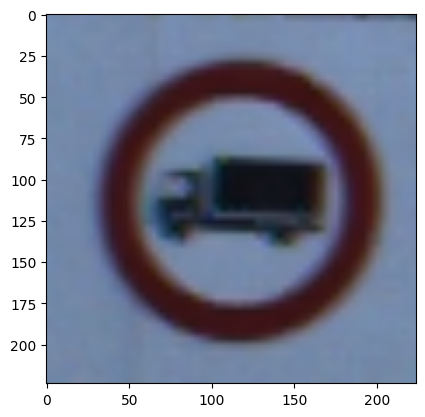

In [38]:
plt.imshow(np.transpose(test[0][0], (1, 2, 0)))

Создаем тепловую карту последнего сверточного слоя сети

In [39]:
to_pil_image(test[0][0]).save("sign.png")
torch.save(model.cpu().state_dict(), "resnet50.pt")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


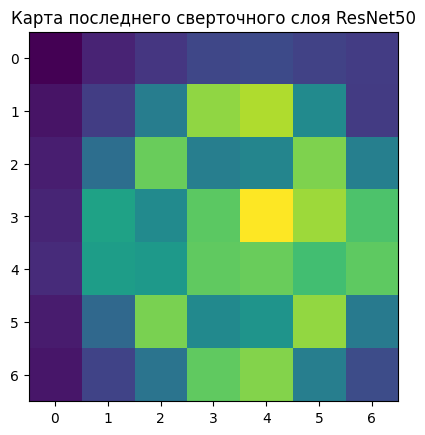

In [40]:
model = resnet50(pretrained=False)
model.fc = nn.Linear(2048, len(unique))
model = model.eval()
model.load_state_dict(torch.load("resnet50.pt"))
cam_extractor = SmoothGradCAMpp(model)
# Открываем картинку
img = read_image("sign.png")
# Предобрабатываем картинку для входа нашей нейронной сети
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Получаем выходные данные на основе модели
out = model(input_tensor.unsqueeze(0))
# Получаем карту активации нейроннов последнего слоя модели resnet18
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
plt.title("Карта последнего сверточного слоя ResNet50")
plt.imshow(np.transpose(activation_map[0].detach().cpu().numpy(), (1, 2, 0)))

Text(0.5, 1.0, 'sign.png')

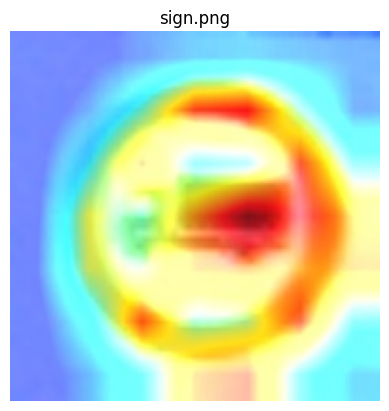

In [41]:
# действия аналогичны разделу 2
img = cv2.imread("sign.png")
heatmap = cv2.resize(activation_map[0].squeeze(0).numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img
plt.imshow(superimposed_img)
output = 'output.jpg'
cv2.imwrite(output, superimposed_img)
img=mpimg.imread(output)
plt.imshow(img)
plt.axis('off')
plt.title("sign.png")

In [42]:
Задание:
1. Создать репозиторий практического занятия на GitHub. (скопировать созданный репозиторий к себе на рабочую машину командой git clone "github.com/ссылка на ваш репозиторий")
2. Сохранить выполненный ноутбук и все выходные файлы. Команды для сохранения:
2.1 git add *
2.2 git commit -am "Familiya_Imya_Otchestvo_prz_1"
2.3 git push

SyntaxError: ignored